# Download files

In [1]:
# Reviews CSV (updated)
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

!wget https://www.dropbox.com/scl/fi/qlppg911v2jge6lcp76n2/BLIP_users_reclists.json.gz?rlkey=i8zehq3dig8ubznelrq5yoknu&st=ft4oo7cl&dl=0
!mv BLIP_users_reclists.json.gz?rlkey=i8zehq3dig8ubznelrq5yoknu BLIP_users_reclists.json.gz

!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=tqfdpqjv&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv


In [2]:
!wget https://www.dropbox.com/scl/fi/j3m7xv2811l6v09v646ty/BLIP_images_descriptions.json.gz?rlkey=d3an8z48kpp1eyzj8v5k197s1&st=c7t76xpf&dl=0
!mv BLIP_images_descriptions.json.gz?rlkey=d3an8z48kpp1eyzj8v5k197s1 BLIP_images_descriptions.json.gz

--2024-12-04 02:10:00--  https://www.dropbox.com/scl/fi/j3m7xv2811l6v09v646ty/BLIP_images_descriptions.json.gz?rlkey=d3an8z48kpp1eyzj8v5k197s1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f7506f025aadd2615251f206a.dl.dropboxusercontent.com/cd/0/inline/CfmXKJyXxejC5XQzw124SiL3W7vtCht7blc2B9tXhF2tldpO5FJwhaClOzaVZ6qvhxX03rSkUCg_86BRNbiraTdtkLpRvzM8qAoK7JCz9xXvChiRFcfrg_11jFnNVQNe8vVtaqXLgPKEKKkwDKWDp3pZ/file# [following]
--2024-12-04 02:10:01--  https://uc9f7506f025aadd2615251f206a.dl.dropboxusercontent.com/cd/0/inline/CfmXKJyXxejC5XQzw124SiL3W7vtCht7blc2B9tXhF2tldpO5FJwhaClOzaVZ6qvhxX03rSkUCg_86BRNbiraTdtkLpRvzM8qAoK7JCz9xXvChiRFcfrg_11jFnNVQNe8vVtaqXLgPKEKKkwDKWDp3pZ/file
Resolving uc9f7506f025aadd2615251f206a.dl.dropboxusercontent.com (uc9f7506f025aadd2615251f206a.dl.dropboxusercontent.com).

# Install Libraries

In [3]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
#!pip install cornac
#!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time


# Clip
from transformers import CLIPProcessor, CLIPModel
from transformers import BitsAndBytesConfig
import torch

In [4]:
from sentence_transformers import SentenceTransformer


In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [6]:
import spacy


In [48]:
import seaborn as sns

In [7]:
%%capture
!pip install fairscale

In [8]:
# install requirements
%%capture
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [9]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


In [10]:
from models.blip import blip_decoder

In [11]:
from collections import Counter

# Data Preprocessing

In [12]:
df = pd.read_csv('/content/reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'/content/reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [13]:
X = df[['user_id', 'rest_id', 'rating']]


restaurants = pd.read_csv('/content/restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

In [14]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('/content/metadata.json.gz'))
metadata = metadata[0]

In [15]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [16]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [17]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

# Utils

In [42]:
# reciprocal rank
def reciprocal_rank(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users

def get_relevant_items(user):
    user_reviews = test_user_items[user]
    user_reviews = list(
        map(lambda x: x[0],
        filter(lambda x: x[1] >= 3.5, user_reviews)
    ))
    return user_reviews

def MAP(model_reclist, n):
    mean_ap = 0.
    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
    mean_ap /= len(test_users)
    return mean_ap

def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        #user_reviews = test_users[u]


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += reciprocal_rank(reclist, user_reviews)


    mean_ap /= len(test_users)
    mean_ndcg /= len(test_users)
    mean_recall /= len(test_users)
    mean_precission /= len(test_users)
    mean_rr /= len(test_users)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')

def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df




# BLIP

## Model Download

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def load_image(image_size, device, path):
    raw_image = Image.open(path).convert('RGB')

    w,h = raw_image.size
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

In [ ]:
# Cargamos el modelo BLIP
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
image_size = 150

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.97G/1.97G [00:07<00:00, 271MB/s]


reshape position embedding from 196 to 81
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [ ]:
MIN_LENGTH = 50
MAX_LENGTH = 200

def generate_caption(image_path):
    image = load_image(image_size=image_size, device=device, path=image_path)
    caption = model.generate(image, sample=True, top_p=0.9, max_length=MAX_LENGTH, min_length=MIN_LENGTH)
    return caption[0]

blip_descriptions_per_image = {}

for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
    image_path = f'../../reviews//{row.img_filename}'
    with torch.no_grad():
        caption = generate_caption(image_path)
    blip_descriptions_per_image[row.gmap_id] = caption


Processing rows: 100%|██████████| 8038/8038 [2:03:01<00:00,  1.09it/s]


In [ ]:
with gzip.open("BLIP_images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(blip_descriptions_per_image, zipfile)

In [ ]:
len(blip_descriptions_per_image)

8038

## Description's model download

In [22]:
blip_imgs_descriptions = list(parse("/content/BLIP_images_descriptions.json.gz"))[0]

In [23]:
# all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384.
for key, value in tqdm(blip_imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)

100%|██████████| 8038/8038 [02:05<00:00, 63.90it/s]


In [25]:
len(imgs_embeddings)

8038

In [26]:
rev_embeddings = {}
for img_filename, emb in imgs_embeddings.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_embeddings[rev_id] = emb

rev_descriptions = {}
for img_filename, description in blip_imgs_descriptions.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_descriptions[rev_id] = description

In [27]:
rev_id2info = X.to_dict('index')

In [28]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

In [29]:
allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))

In [30]:
print(len(user_reviews.keys()))

7254


In [31]:
print(allreviews.min())
print(allreviews.mean())
print(allreviews.max())

1
1.1080783016266886
10


In [32]:
count_reviews = Counter(allreviews)
for k, v in sorted(count_reviews.items(), key=lambda x: x[0]):
    print(f'{k:<2} {v:>5}')

1   6700
2    423
3     79
4     27
5     13
6      7
7      3
9      1
10     1


In [33]:
train_set, test_set = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        train_set.append(reviews)
    else:
        if 1 < len(reviews) <= 3:           # 2 o 3 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:         # 4 o 5 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:                               # 6 o + reviews
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)
        train_set.append(train_data)
        test_set.append(test_data)


In [34]:
x_train, x_test = [], []
for d in train_set:
    x_train.extend(d)
for d in test_set:
    x_test.extend(d)

In [35]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [36]:
train_embeddings = list(map(lambda x: rev_embeddings[x[0]], x_train))

In [37]:
test_users = {}
for x in x_test:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not test_users.get(user_id):
        test_users[user_id] = []
    test_users[user_id].append(rev_id)

In [38]:
train_users = {}
for x in x_train:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not train_users.get(user_id):
        train_users[user_id] = []
    train_users[user_id].append(rev_id)

In [39]:
def get_test_embedding(user_id, reviews, mode='knn'):
    # @Input: Obtenemos el id de un usuario y los ids de sus reviews realizadas
    # Si el usuario solo hizo una review en testing, entonces retornamos el embedding de solo esa review.
    if len(reviews) <= 1:
        rev_id = reviews[0]

        return rev_embeddings[rev_id]

    # Si hizo al menos 2 reviews, usamos similitud del coseno para ver que review de testing
    # es la que presenta mayor similitud con las reviews del training.
    # Escogemos la review con la similitud mas alta.

    user_train_revs = train_users[user_id]  # Reviews realizadas por el usuario (train)
    user_test_revs = reviews                # Reviews de testing del usuario (por predecir)

    user_train_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_train_revs))

     # En el caso que sea mean, retornamos el promedio de las reviews de train
    if mode == 'mean':
        user_test_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_test_revs))
        return np.mean(user_test_embeddings, axis=0)


    max_sim_test_idx = -1                   # Indice de la review de testing que tiene maxima similitud
    max_sim_value = -1                      # Valor de similitud maximo alcanzado

    for test_idx, rev_id in enumerate(user_test_revs):
        user_test_embedding = rev_embeddings[rev_id]

        similarities = encoder.similarity(user_test_embedding, user_train_embeddings).cpu().numpy()[0]
        max_curr_sim = similarities.mean()

        if max_sim_value < max_curr_sim:
            max_sim_value = max_curr_sim    # actualizamos el valor mas alto de similitud
            max_sim_test_idx = test_idx     # actualizamos el indice del test embedding con mas similitud


    # Escogemos el embedding con maxima similitud.

    best_id = user_test_revs[max_sim_test_idx]
    best_test_embedding = rev_embeddings[best_id]

    return best_test_embedding

In [46]:
def blip_train(train_users, test_users, mode='knn', k_values=[10,20]):
    blip_reclists = {}

    for user_id, reviews in tqdm(test_users.items(), desc="Procesando ... "):
        blip_reclists[user_id] =  { k : [] for k in k_values }
        test_embedding = get_test_embedding(user_id, reviews, mode)

        # Realizamos "KNN" para buscar los embeddings del training mas cercanos con
        # respecto al embedding de testing

        similarities = encoder.similarity(test_embedding, train_embeddings).cpu().numpy()[0]

        # Ordenamos de mayor a menor.

        sorted_idxs = similarities.argsort()[::-1]

        # Aca realizamos el KNN-k, con k en {10, 20}.
        for k in k_values:
            recommended_restaurants_k = []

            for idx in sorted_idxs:
                rest_id = x_train[idx][1] # Rest ID

                # Como son reviews, pueden ser del mismo restaurant -> Aseguramos no duplicados
                if rest_id not in recommended_restaurants_k:
                    recommended_restaurants_k.append(rest_id)
                    blip_reclists[user_id][k].append(rest_id)

                if len(recommended_restaurants_k) == k:
                    break
    # Guardamos la lista de recomendaciones
    with gzip.open("BLIP_users_reclists.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(blip_reclists, zipfile)

    return blip_reclists

In [41]:
test_user_items = {} # Usuario de testing y restaurantes evaluados ...
for user, reviews in test_users.items():
    test_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

# Sensitivity analysis

In [47]:
k_values = [5, 10, 20, 30, 50]
blip_most_sim_reclist = blip_train(train_users, test_users, mode='knn', k_values=k_values)
blip_mean_reclist = blip_train(train_users, test_users, mode='mean', k_values=k_values)

Procesando ... : 100%|██████████| 554/554 [02:40<00:00,  3.46it/s]


In [49]:
global_blip_most_sim_reclists_k = { k : None for k in k_values }
global_blip_mean_reclists_k = { k : None for k in k_values }

for k in k_values:
    # Vamos por usuario y guardamos segun valor de lista
    blip_most_sim_reclist_k, blip_mean_reclist_k = {}, {}

    # LLaVA Most similar
    for user_id, reclists in blip_most_sim_reclist.items():
        blip_most_sim_reclist_k[user_id] = reclists[k]
    global_blip_most_sim_reclists_k[k] = blip_most_sim_reclist_k

    # LLaVA Mean
    for user_id, reclists in blip_mean_reclist.items():
        blip_mean_reclist_k[user_id] = reclists[k]
    global_blip_mean_reclists_k[k] = blip_mean_reclist_k


In [50]:
map_values = []
for k in k_values:
    map_blip_most_sim = MAP(global_blip_most_sim_reclists_k[k], k)
    map_blip_mean = MAP(global_blip_mean_reclists_k[k], k)
    map_values.append((map_blip_most_sim, map_blip_mean))

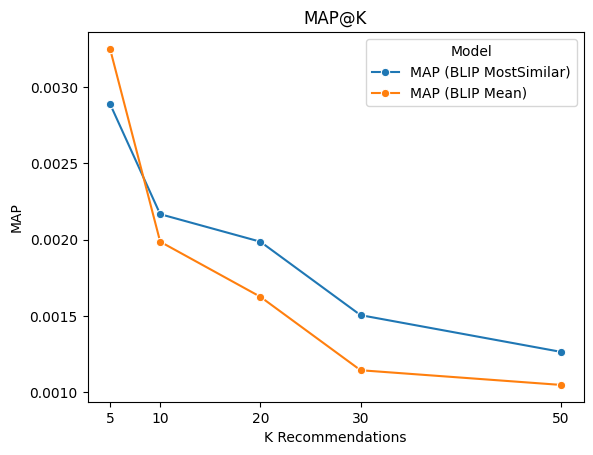

In [58]:
models = ['LLaVA (MostSimilar)', 'LLaVA (Mean)']

blip_mostsim_map_values, blip_mean_map_values = list(zip(*map_values))
df_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'MAP (BLIP MostSimilar)' : blip_mostsim_map_values,
    'MAP (BLIP Mean)' : blip_mean_map_values
})

df_plot = df_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='MAP'
)
plt.title('MAP@K')
sns.lineplot(data=df_plot, x='K Recommendations', y='MAP', hue='Model', marker='o')
plt.xticks(k_values)
plt.show()

In [52]:
novelty_values = []
diversity_values = []

for k in k_values:
    novelty_blip_most_sim = novelty(global_blip_most_sim_reclists_k[k])
    diversity_blip_most_sim = diversity(global_blip_most_sim_reclists_k[k])

    novelty_blip_mean = novelty(global_blip_mean_reclists_k[k])
    diversity_blip_mean = diversity(global_blip_mean_reclists_k[k])

    novelty_values.append((novelty_blip_most_sim, novelty_blip_mean))
    diversity_values.append((diversity_blip_most_sim, diversity_blip_mean))

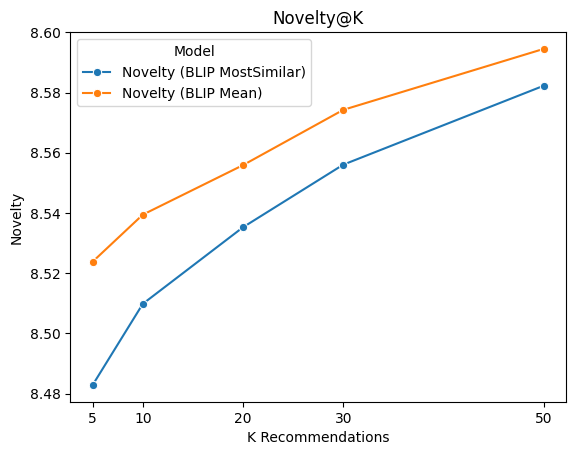

In [59]:
blip_mostsim_novelty_values, blip_mean_novelty_values = list(zip(*novelty_values))

df_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Novelty (BLIP MostSimilar)': blip_mostsim_novelty_values,
    'Novelty (BLIP Mean)': blip_mean_novelty_values
})

df_plot = df_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Novelty'
)

sns.lineplot(data=df_plot, x='K Recommendations', y='Novelty', hue='Model', marker='o')
plt.xticks(k_values)
plt.title("Novelty@K")
plt.xlabel("K Recommendations")
plt.ylabel("Novelty")
plt.legend(title='Model')
plt.show()


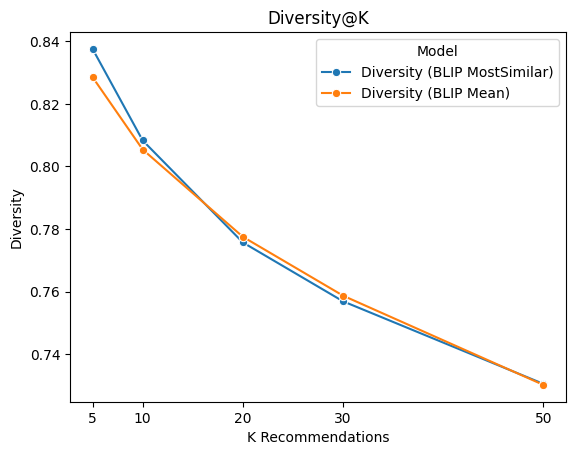

In [60]:
blip_mostsim_diversity_values, blip_mean_diversity_values = list(zip(*diversity_values))

df_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Diversity (BLIP MostSimilar)': blip_mostsim_diversity_values,
    'Diversity (BLIP Mean)': blip_mean_diversity_values
})

df_plot = df_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Diversity'
)

sns.lineplot(data=df_plot, x='K Recommendations', y='Diversity', hue='Model', marker='o')
plt.xticks(k_values)
plt.title("Diversity@K")
plt.xlabel("K Recommendations")
plt.ylabel("Diversity")
plt.legend(title='Model')
plt.show()


# Results

## BLIP - Most Similar

In [ ]:
print('BLIP (Case 1: Most Similar)')
blip_most_sim_reclist = blip_train(train_users, test_users, mode='knn')

BLIP (Case 1: Most Similar)


Procesando ... : 100%|██████████| 554/554 [02:40<00:00,  3.44it/s]


### Metrics

In [ ]:
blip_most_sim_reclist10, blip_most_sim_reclist20 = {}, {}

for user_id, reclists in blip_most_sim_reclist.items():
    blip_most_sim_reclist10[user_id] = reclists[10]
    blip_most_sim_reclist20[user_id] = reclists[20]

In [ ]:
evaluate_model(blip_most_sim_reclist10, n=10)

MAP@10: 0.0021660649819494585
nDCG@10: 0.017352251250479168
Recall@10: 0.017148014440433214
Precision@10: 0.001985559566787003
MRR@10: 0.009280986762936221
Novelty@10: 8.509800858725535
Diversity@10: 0.8083032490974724


In [ ]:
evaluate_model(blip_most_sim_reclist20, n=20)

MAP@20: 0.001985559566787004
nDCG@20: 0.031094394197709242
Recall@20: 0.030685920577617327
Precision@20: 0.0018953068592057767
MRR@20: 0.010522377978313421
Novelty@20: 8.5352491432086
Diversity@20: 0.7757220216606494


### Examples

In [ ]:
random_user = '100012107238749468669'
show_recommendations(
    user=random_user,
    reclist=blip_most_sim_reclist10[random_user]
)

,name,description,categories
0,AsiaSF Palm Springs,NaN,Restaurant
1,The Big Easy,NaN,Night club;Restaurant;Bar;Dinner theater
2,La Maison Kabob,NaN,Mediterranean restaurant;Bar;Sports bar
3,Bowery Coastal,"Live music in a large, memorabilia-filled spac...",Seafood restaurant;New American restaurant;Bar...
4,Gertrude's Jazz Bar,Nightly music from jazz & blues to rock in a m...,Night club;Live music venue;Restaurant;Bar;Tap...
5,The Ante Room,NaN,Night club;Live music venue;American restauran...
6,K2 Restaurant and Lounge,Relaxed American eatery with a bar streaming s...,Seafood restaurant;Bar & grill;Sports bar
7,TSR TYSONS,"High-energy Latin nightclub & bar with DJs, da...",Night club;Club;Lounge;Fusion restaurant
8,Bottles,NaN,Restaurant
9,Blue Mountain Barrel House & Smokin' Barrel Re...,NaN,Brewery;Restaurant


In [ ]:
show_recommendations(
    user=random_user,
    reclist=blip_most_sim_reclist20[random_user]
)

,name,description,categories
0,AsiaSF Palm Springs,NaN,Restaurant
1,Panamerican Night Club (Oficial),Hopping nightspot offering Latin American musi...,Night club;Bar;Restaurant
2,Avenue italy,NaN,Italian restaurant
3,The Big Easy,NaN,Night club;Restaurant;Bar;Dinner theater
4,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
5,Hot Pot Grill Buffet,NaN,Restaurant
6,La Maison Kabob,NaN,Mediterranean restaurant;Bar;Sports bar
7,Bowery Coastal,"Live music in a large, memorabilia-filled spac...",Seafood restaurant;New American restaurant;Bar...
8,LOCALE Eatery,NaN,Coffee shop;Italian restaurant;Sandwich shop;M...
9,Benni Jama,NaN,Cuban restaurant


## BLIP - Mean

In [ ]:
print('BLIP (Case 1: Most Similar)')
blip_mean_reclist = blip_train(train_users, test_users, mode='mean')

BLIP (Case 1: Most Similar)


Procesando ... : 100%|██████████| 554/554 [02:38<00:00,  3.50it/s]


### Metrics

In [ ]:
blip_mean_reclist10, blip_mean_reclist20 = {}, {}

for user_id, reclists in blip_mean_reclist.items():
    blip_mean_reclist10[user_id] = reclists[10]
    blip_mean_reclist20[user_id] = reclists[20]

In [ ]:
evaluate_model(blip_mean_reclist10, n=10)

MAP@10: 0.0019855595667870036
nDCG@10: 0.01694377763038726
Recall@10: 0.017148014440433214
Precision@10: 0.0018050541516245486
MRR@10: 0.008799638989169675
Novelty@10: 8.539434127282307
Diversity@10: 0.8054151624548728


In [ ]:
evaluate_model(blip_mean_reclist20, n=20)

MAP@20: 0.0016245487364620942
nDCG@20: 0.028472392805900873
Recall@20: 0.02888086642599278
Precision@20: 0.0015342960288808668
MRR@20: 0.009630763811587766
Novelty@20: 8.555894825953509
Diversity@20: 0.7775270758122742


### Examples

In [ ]:
show_recommendations(
    user=random_user,
    reclist=blip_mean_reclist10[random_user]
)

,name,description,categories
0,AsiaSF Palm Springs,NaN,Restaurant
1,The Big Easy,NaN,Night club;Restaurant;Bar;Dinner theater
2,La Maison Kabob,NaN,Mediterranean restaurant;Bar;Sports bar
3,Bowery Coastal,"Live music in a large, memorabilia-filled spac...",Seafood restaurant;New American restaurant;Bar...
4,Gertrude's Jazz Bar,Nightly music from jazz & blues to rock in a m...,Night club;Live music venue;Restaurant;Bar;Tap...
5,The Ante Room,NaN,Night club;Live music venue;American restauran...
6,K2 Restaurant and Lounge,Relaxed American eatery with a bar streaming s...,Seafood restaurant;Bar & grill;Sports bar
7,TSR TYSONS,"High-energy Latin nightclub & bar with DJs, da...",Night club;Club;Lounge;Fusion restaurant
8,Bottles,NaN,Restaurant
9,Blue Mountain Barrel House & Smokin' Barrel Re...,NaN,Brewery;Restaurant


In [ ]:
show_recommendations(
    user=random_user,
    reclist=blip_mean_reclist20[random_user]
)

,name,description,categories
0,AsiaSF Palm Springs,NaN,Restaurant
1,Panamerican Night Club (Oficial),Hopping nightspot offering Latin American musi...,Night club;Bar;Restaurant
2,Avenue italy,NaN,Italian restaurant
3,The Big Easy,NaN,Night club;Restaurant;Bar;Dinner theater
4,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
5,Hot Pot Grill Buffet,NaN,Restaurant
6,La Maison Kabob,NaN,Mediterranean restaurant;Bar;Sports bar
7,Bowery Coastal,"Live music in a large, memorabilia-filled spac...",Seafood restaurant;New American restaurant;Bar...
8,LOCALE Eatery,NaN,Coffee shop;Italian restaurant;Sandwich shop;M...
9,Benni Jama,NaN,Cuban restaurant


## Descriptions on BlIP recommendations

In [ ]:
def print_descriptions(reclist):

    for rest_id in reclist:
        rest_name = restaurants_dict[rest_id]['name']
        print('\n', rest_name.upper(), '\n')
        for desc in restaurants_descriptions[rest_name]:
            sentences = desc.split('.')
            for sentence in sentences:
                if len(sentence) > 100:
                    sentence = sentence.split(',')
                    for part in sentence:
                        print(part)
                else:
                    print(sentence)


        print('\n' * 1)
        print('-' * 100)

In [ ]:
restaurants_descriptions = {}
for rev_id, description in rev_descriptions.items():

    rest_id = rev_id2info[rev_id]['rest_id']
    rest_name = restaurants_dict[rest_id]['name']

    if not restaurants_descriptions.get(rest_name):
        restaurants_descriptions[rest_name] = []

    restaurants_descriptions[rest_name].append(description)


In [ ]:
print_descriptions(blip_most_sim_reclist10[random_user])


 LA MAISON KABOB 

the stage at a nightclub with several people watching and singing on their phones
 in front of the big screen that reads live show the lights live music at the night tour 2iwhappmvbwdcpkc


----------------------------------------------------------------------------------------------------

 GERTRUDE'S JAZZ BAR 

a concert scene with a band playing on the stage
 at the bottom right is an event poster and lights are visible in the othera in the picture inlay sa0s s s and l xo p
 l?


----------------------------------------------------------------------------------------------------

 BOWERY COASTAL 

a band playing at night on stage with neon lights
 lit up the night sky behind
 and red neon sign for an event and bright thumb template text ayy of sxfv22s74
 y6


----------------------------------------------------------------------------------------------------

 THE BIG EASY 

an event with music and people in it and a stage with instruments and musicians in the ba

In [ ]:
print_descriptions(blip_mean_reclist10[random_user])


 LA MAISON KABOB 

the stage at a nightclub with several people watching and singing on their phones
 in front of the big screen that reads live show the lights live music at the night tour 2iwhappmvbwdcpkc


----------------------------------------------------------------------------------------------------

 GERTRUDE'S JAZZ BAR 

a concert scene with a band playing on the stage
 at the bottom right is an event poster and lights are visible in the othera in the picture inlay sa0s s s and l xo p
 l?


----------------------------------------------------------------------------------------------------

 BOWERY COASTAL 

a band playing at night on stage with neon lights
 lit up the night sky behind
 and red neon sign for an event and bright thumb template text ayy of sxfv22s74
 y6


----------------------------------------------------------------------------------------------------

 THE BIG EASY 

an event with music and people in it and a stage with instruments and musicians in the ba